<a href="https://colab.research.google.com/github/ApoorvaNagarajan/Image-Filter-Kernels/blob/master/assignment25/assignment25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing all python packages

In [0]:
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.preprocessing import image

import matplotlib.pyplot as plt

import sys

import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#Load the dataset

NUM_IMGS = 621

X_train = np.zeros((NUM_IMGS, 100, 100, 3))

for i in range(0,NUM_IMGS):
  img = image.load_img('/content/drive/My Drive/datasets/car_dataset/img_' + str(i) + '.jpg')
  X_train[i] = img;


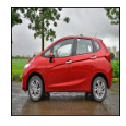

In [35]:
plt.rcParams['figure.figsize'] = (2,2)
f, ax = plt.subplots(1, 1)
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(X_train[2].astype('int32'))

In [0]:
# Rescale -1 to 1
X_train = X_train / 127.5 - 1.

In [37]:
print(X_train.shape)

(621, 100, 100, 3)


In [0]:
class DCGAN():
    def __init__(self):
        # Input shape
        self.img_rows = 100
        self.img_cols = 100
        self.channels = 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 256

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def build_generator(self):

        model = Sequential()

        model.add(Dense(256 * 13 * 13, activation="relu", input_dim=self.latent_dim))
        model.add(Reshape((13, 13, 256)))
        model.add(UpSampling2D())
        model.add(Conv2D(256, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=3))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(Conv2D(self.channels, kernel_size=3))
        model.add(Activation("tanh"))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same")) # 100x100x3 -> 50x50x32
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same")) # 25x25x64
        model.add(ZeroPadding2D(padding=((0,1),(0,1)))) # 26x26x64
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same")) # 13x13x128
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(256, kernel_size=3, strides=1, padding="same")) # 13x13x256
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))

        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, save_interval=50):

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            # Sample noise and generate a batch of new images
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator (real classified as ones and generated as zeros)
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            # Train the generator (wants discriminator to mistake images as real)
            g_loss = self.combined.train_on_batch(noise, valid)

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % save_interval == 0:
                self.save_imgs(epoch)

    def save_imgs(self, epoch):
        r, c = 10, 10
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c, figsize = (20, 20))
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,:])
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("/content/drive/My Drive/assignment25_results/car_%d.png" % epoch)
        plt.close()

In [64]:
dcgan = DCGAN()
dcgan.train(epochs=40000, batch_size=32, save_interval=500)

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_98 (Conv2D)           (None, 50, 50, 32)        896       
_________________________________________________________________
leaky_re_lu_53 (LeakyReLU)   (None, 50, 50, 32)        0         
_________________________________________________________________
dropout_53 (Dropout)         (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_99 (Conv2D)           (None, 25, 25, 64)        18496     
_________________________________________________________________
zero_padding2d_14 (ZeroPaddi (None, 26, 26, 64)        0         
_________________________________________________________________
batch_normalization_73 (Batc (None, 26, 26, 64)        256       
_________________________________________________________________
leaky_re_lu_54 (LeakyReLU)   (None, 26, 26, 64)      

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 1.971672, acc.: 18.75%] [G loss: 0.503739]


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1 [D loss: 0.671173, acc.: 65.62%] [G loss: 1.731049]
2 [D loss: 0.601395, acc.: 59.38%] [G loss: 1.768814]
3 [D loss: 0.680708, acc.: 64.06%] [G loss: 1.832734]
4 [D loss: 0.548420, acc.: 67.19%] [G loss: 1.357700]
5 [D loss: 0.571055, acc.: 71.88%] [G loss: 1.802091]
6 [D loss: 0.515476, acc.: 73.44%] [G loss: 1.599594]
7 [D loss: 0.609014, acc.: 68.75%] [G loss: 1.309577]
8 [D loss: 0.449175, acc.: 71.88%] [G loss: 1.218614]
9 [D loss: 0.519427, acc.: 71.88%] [G loss: 1.938625]
10 [D loss: 0.703599, acc.: 62.50%] [G loss: 2.662915]
11 [D loss: 0.781833, acc.: 56.25%] [G loss: 2.786458]
12 [D loss: 0.903779, acc.: 48.44%] [G loss: 2.271419]
13 [D loss: 1.103523, acc.: 46.88%] [G loss: 1.485211]
14 [D loss: 0.429724, acc.: 82.81%] [G loss: 1.444667]
15 [D loss: 0.478533, acc.: 76.56%] [G loss: 1.422378]
16 [D loss: 0.688369, acc.: 67.19%] [G loss: 1.412514]
17 [D loss: 0.759564, acc.: 59.38%] [G loss: 1.539152]
18 [D loss: 1.023037, acc.: 50.00%] [G loss: 2.808134]
19 [D loss: 1.21669